In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import re
import string
import warnings
from itertools import chain
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
import src.modeling.simulation_based_calibration_helpers as sbc
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.exceptions import CacheDoesNotExistError
from src.globals import PYMC3
from src.io import cache_io
from src.loggers import logger, set_console_handler_level
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_seven import SpecletSeven, SpecletSevenConfiguration
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor
from src.project_enums import MockDataSize, ModelFitMethod

In [4]:
notebook_tic = time()

set_console_handler_level(logging.WARNING)
warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 838
np.random.seed(RANDOM_SEED)

In [5]:
sp7 = SpecletSeven("sp7-expt", debug=True)

In [6]:
if True:
    sp7._reset_model_and_results()
    sp7.cache_manager.clear_mcmc_cache()
    sp7.cache_manager.clear_advi_cache()

[07/14/21 14:02:56] WARNING  Reseting all model and results.             ]8;id=1626285776.6849787-369881;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:144

In [7]:
sbc_dir = sp7.cache_manager.cache_dir / "sbc"

if not sbc_dir.exists():
    sbc_dir.mkdir()


mock_data: pd.DataFrame
sp7_sbc_res: sbc.SBCResults
sp7_sbc_fm: sbc.SBCFileManager

try:
    print("Trying to retrieve SBC data and results.")
    mock_data, sp7_sbc_res, sp7_sbc_fm = sp7.get_sbc(sbc_dir)
    print("Successfully retrieved SBC results from cache.")
except CacheDoesNotExistError:
    print("Unable to retrieve SBC results from cache --> running SBC")
    sp7.run_simulation_based_calibration(
        results_path=sbc_dir,
        fit_method=ModelFitMethod.MCMC,
        random_seed=RANDOM_SEED,
        size=MockDataSize.MEDIUM,
        fit_kwargs={
            "draws": 1000,
            "tune": 2000,
            "chains": 2,
            "cores": 2,
            "prior_pred_samples": 1000,
            "post_pred_samples": 1000,
            "target_accept": 0.95,
        },
    )
    mock_data = sp7.data_manager.get_data()
    sp7_sbc_fm = sbc.SBCFileManager(sbc_dir)
    sp7_sbc_res = sp7_sbc_fm.get_sbc_results()
except Exception as err:
    print("Unexpected error.")
    print(err)

Trying to retrieve SBC data and results.


[07/14/21 14:02:57] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626285777.3272793-549898;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626285777.3329237-750193;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

Successfully retrieved SBC results from cache.


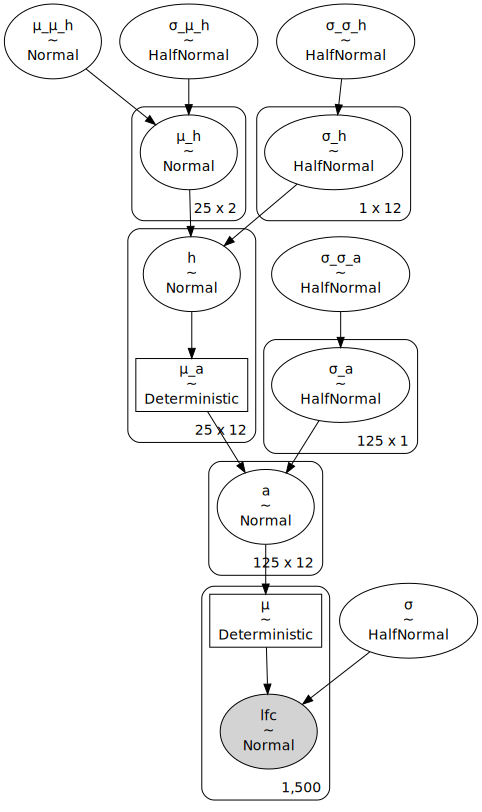

In [8]:
pm.model_to_graphviz(sp7.model)

## Visualization of the mock data

In [9]:
mock_data.head()

depmap_id hugo_symbol   lineage p_dna_batch   screen sgrna_target_chr  \
0  cellline0       gene0  lineage0      batch0  screen0             Chr1   
1  cellline0       gene0  lineage0      batch0  screen0             Chr1   
2  cellline0       gene0  lineage0      batch0  screen0             Chr1   
3  cellline0       gene0  lineage0      batch0  screen0             Chr1   
4  cellline0       gene0  lineage0      batch0  screen0             Chr1   

          sgrna  copy_number   rna_expr  is_mutated       lfc  \
0  gene0_sgrna0     1.113329  14.925597           0  3.742756   
1  gene0_sgrna1     1.113329  14.925597           0  2.449826   
2  gene0_sgrna2     1.113329  14.925597           0  1.885977   
3  gene0_sgrna3     1.113329  14.925597           0  2.421580   
4  gene0_sgrna4     1.113329  14.925597           0  3.818174   

   copy_number_cellline  copy_number_gene  rna_expr_gene_lineage  \
0               0.08258          0.134077               1.026061   
1               0.08258          0.134077               1.026061   
2               0.08258          0.134077               1.026061   
3               0.08258          0.134077               1.026061   
4               0.08258          0.134077               1.026061   

   copy_number_cellline  copy_number_gene  
0               0.08258          0.134077  
1               0.08258          0.134077  
2               0.08258          0.134077  
3               0.08258          0.134077  
4               0.08258          0.134077

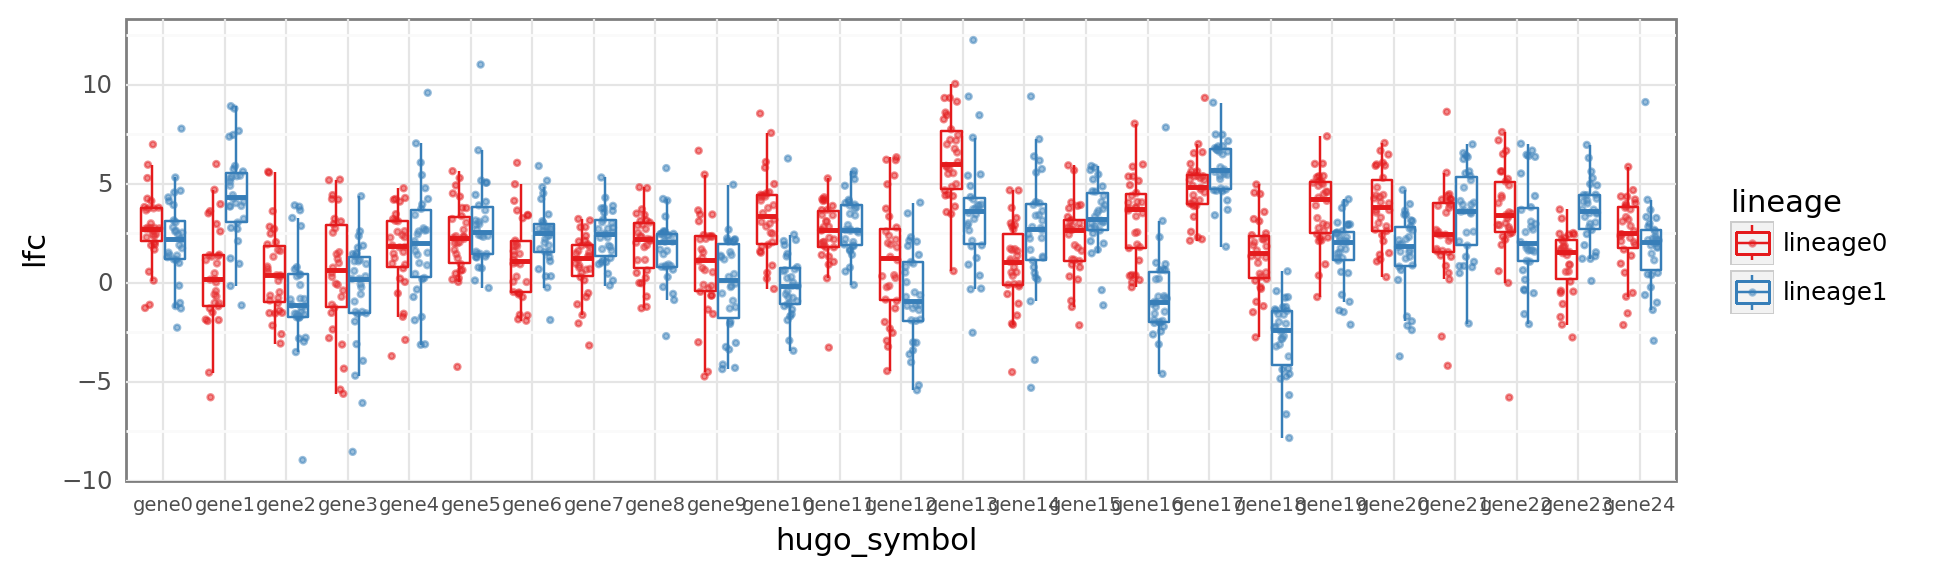

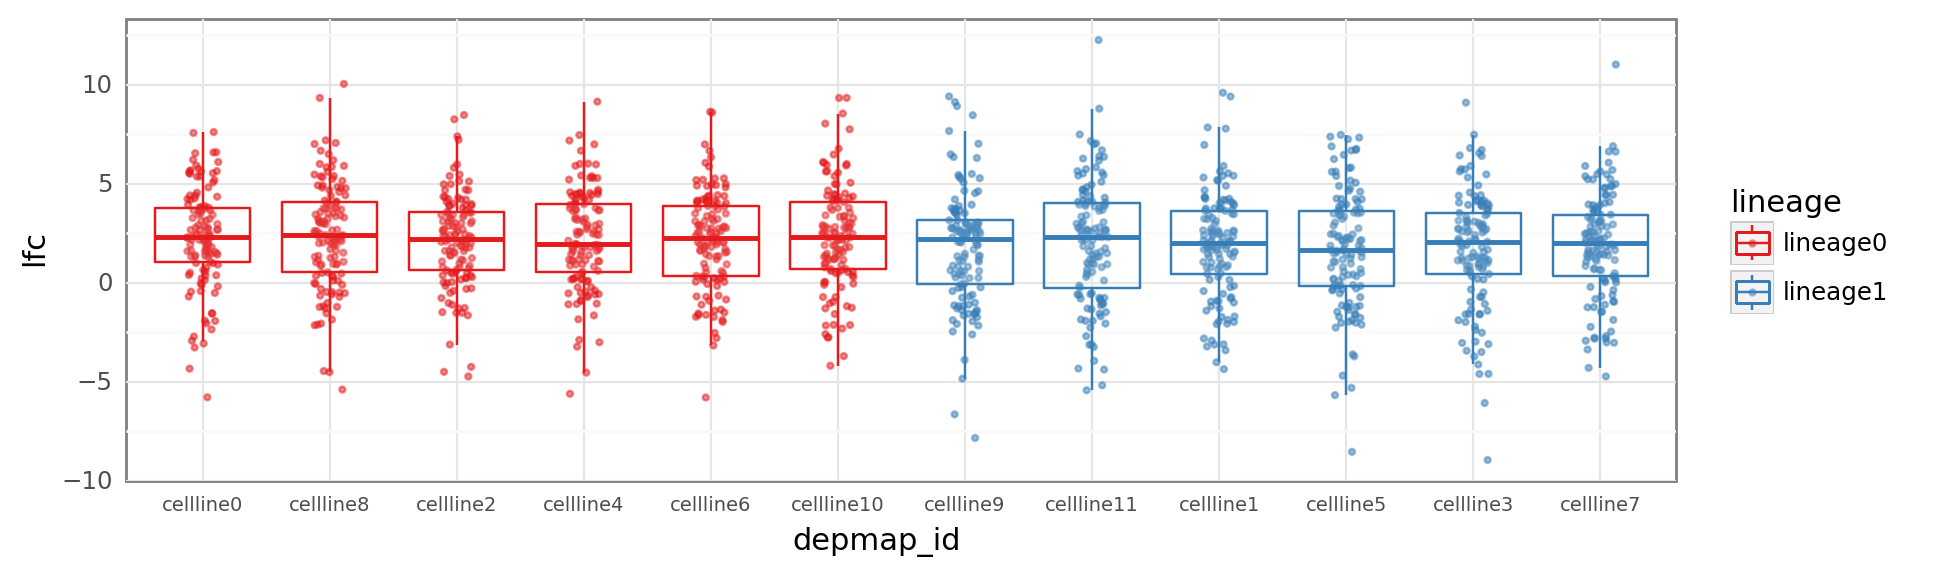

In [10]:
for x in ["hugo_symbol", "depmap_id"]:
    pos = gg.position_jitterdodge(jitter_width=0.5, jitter_height=0, random_state=0)
    (
        gg.ggplot(mock_data, gg.aes(x=x, y="lfc"))
        + gg.geom_jitter(gg.aes(color="lineage"), alpha=0.5, size=0.7, position=pos)
        + gg.geom_boxplot(gg.aes(color="lineage"), outlier_alpha=0, alpha=0.1)
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.theme(axis_text_x=gg.element_text(size=7), figure_size=(10, 3))
    ).draw()

## Model priors

In [11]:
with sp7.model:
    prior_dist = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

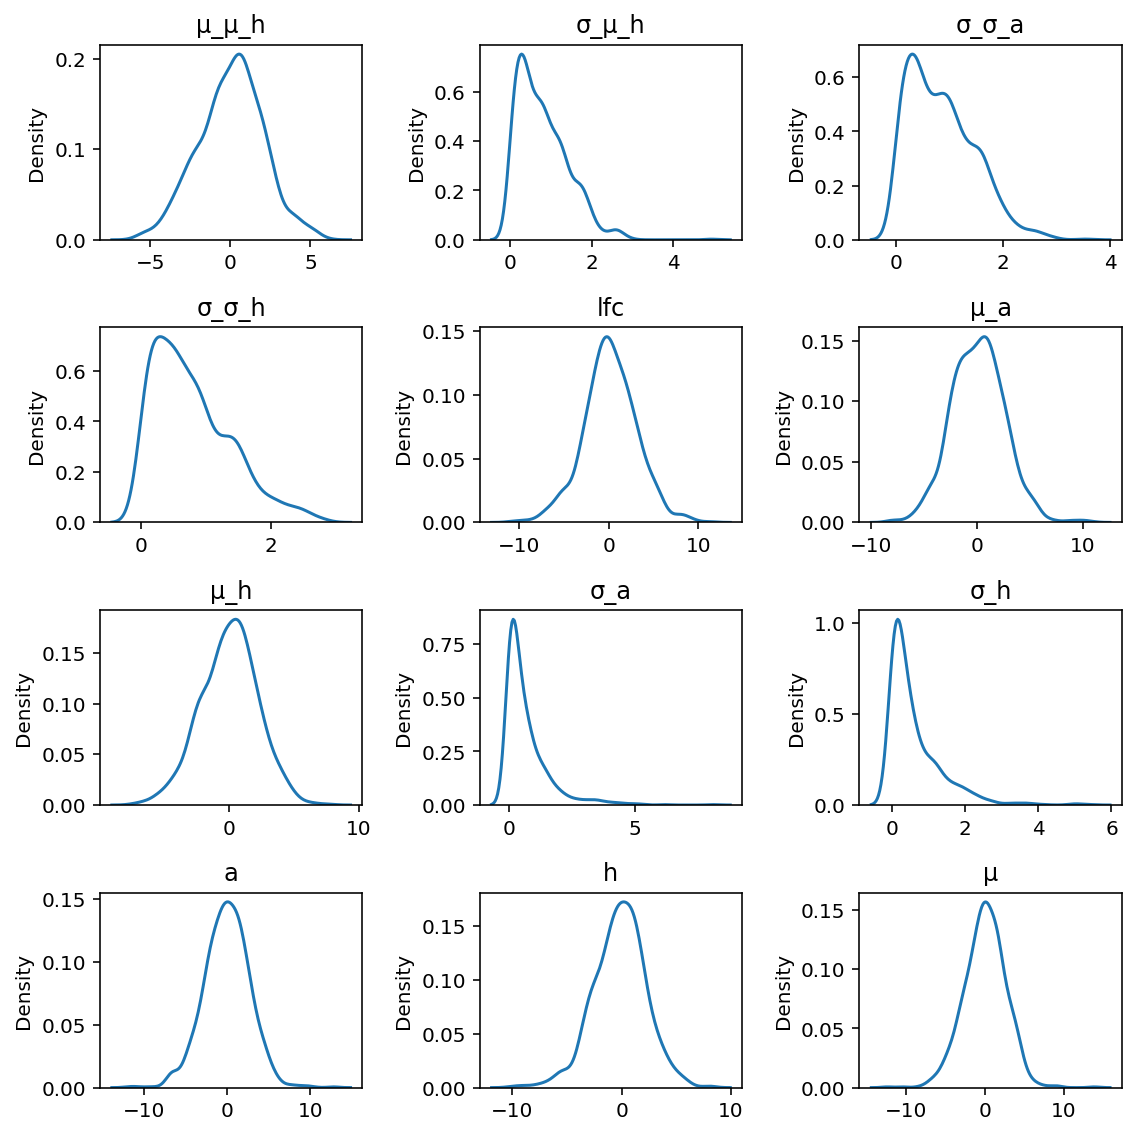

In [12]:
pmanal.plot_all_priors(prior_dist, (4, 3), (8, 8), rm_var_regex="log__|logodds_|offset");

## Model posterior estimates

In [13]:
sp7_mcmc = sp7_sbc_res.inference_obj

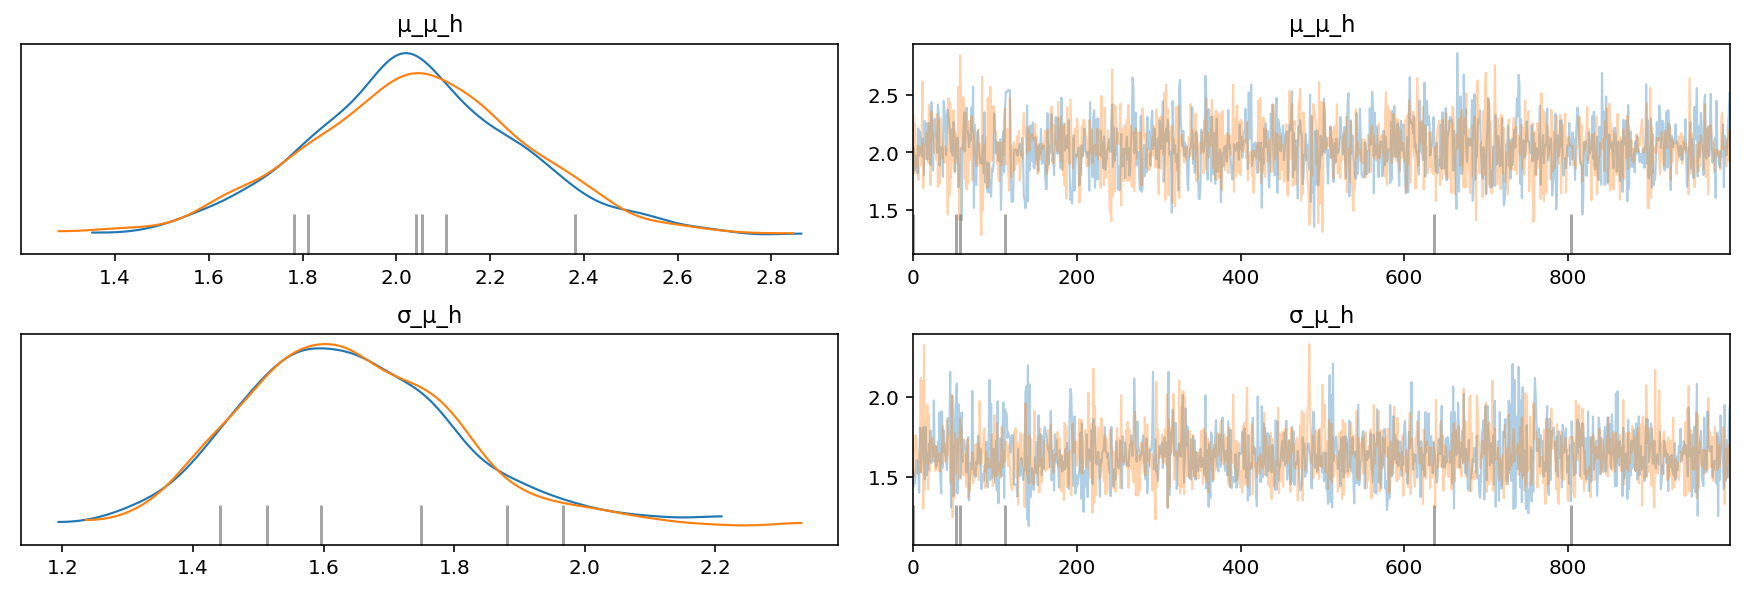

In [14]:
top_h_var_names = ["μ_μ_h", "σ_μ_h"]
az.plot_trace(sp7_mcmc, var_names=top_h_var_names, compact=False);

In [15]:
az.summary(sp7_mcmc, var_names=top_h_var_names, hdi_prob=PYMC3.HDI_PROB).assign(
    real_value=np.array([sp7_sbc_res.priors[v] for v in top_h_var_names])
)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
μ_μ_h  2.039  0.232     1.675      2.421      0.006    0.004    1773.0   
σ_μ_h  1.641  0.164     1.382      1.886      0.004    0.003    1882.0   

       ess_tail  r_hat  real_value  
μ_μ_h    1152.0    1.0    1.760227  
σ_μ_h    1104.0    1.0    1.867117

In [16]:
cell_lines = mock_data["depmap_id"].cat.categories.values
genes = mock_data["hugo_symbol"].cat.categories.values

In [17]:
gene_lineage_priors = pd.DataFrame(
    {
        "prior_effect": sp7_sbc_res.priors["μ_a"].squeeze().flatten(),
        "hugo_symbol": np.repeat(genes, len(cell_lines)),
        "depmap_id": np.tile(cell_lines, len(genes)),
    }
).merge(
    mock_data[["depmap_id", "lineage"]].drop_duplicates().reset_index(drop=True),
    on="depmap_id",
)

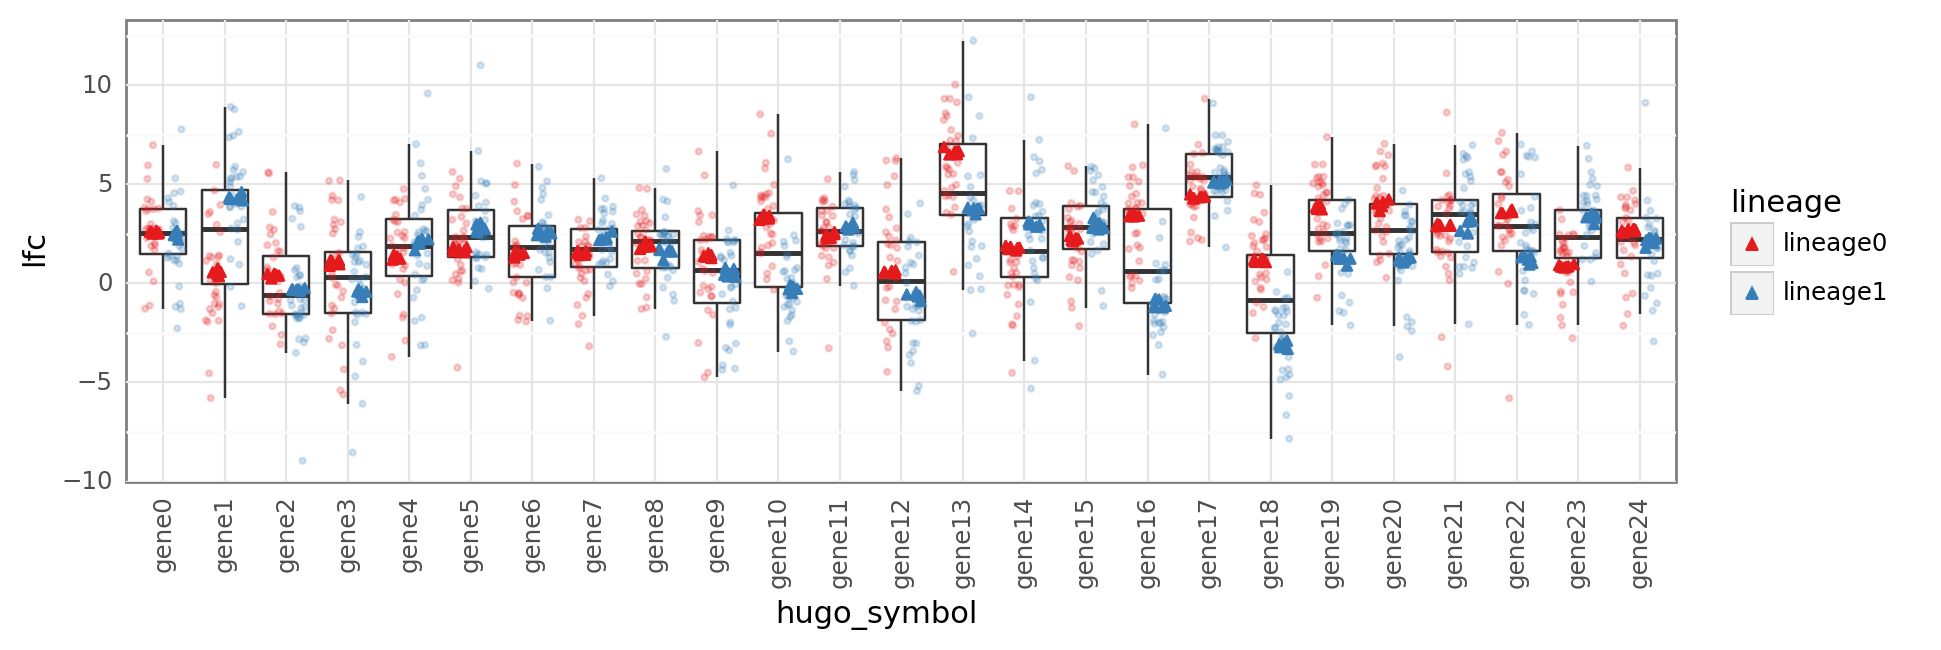

<ggplot: (8734092754815)>

In [18]:
pos = gg.position_jitterdodge(jitter_height=0, jitter_width=0.5, random_state=0)
(
    gg.ggplot(mock_data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.geom_jitter(gg.aes(color="lineage"), alpha=0.2, size=0.7, position=pos)
    + gg.geom_jitter(
        gg.aes(x="hugo_symbol", y="prior_effect", color="lineage"),
        data=gene_lineage_priors,
        shape="^",
        position=pos,
    )
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90), figure_size=(10, 3))
)

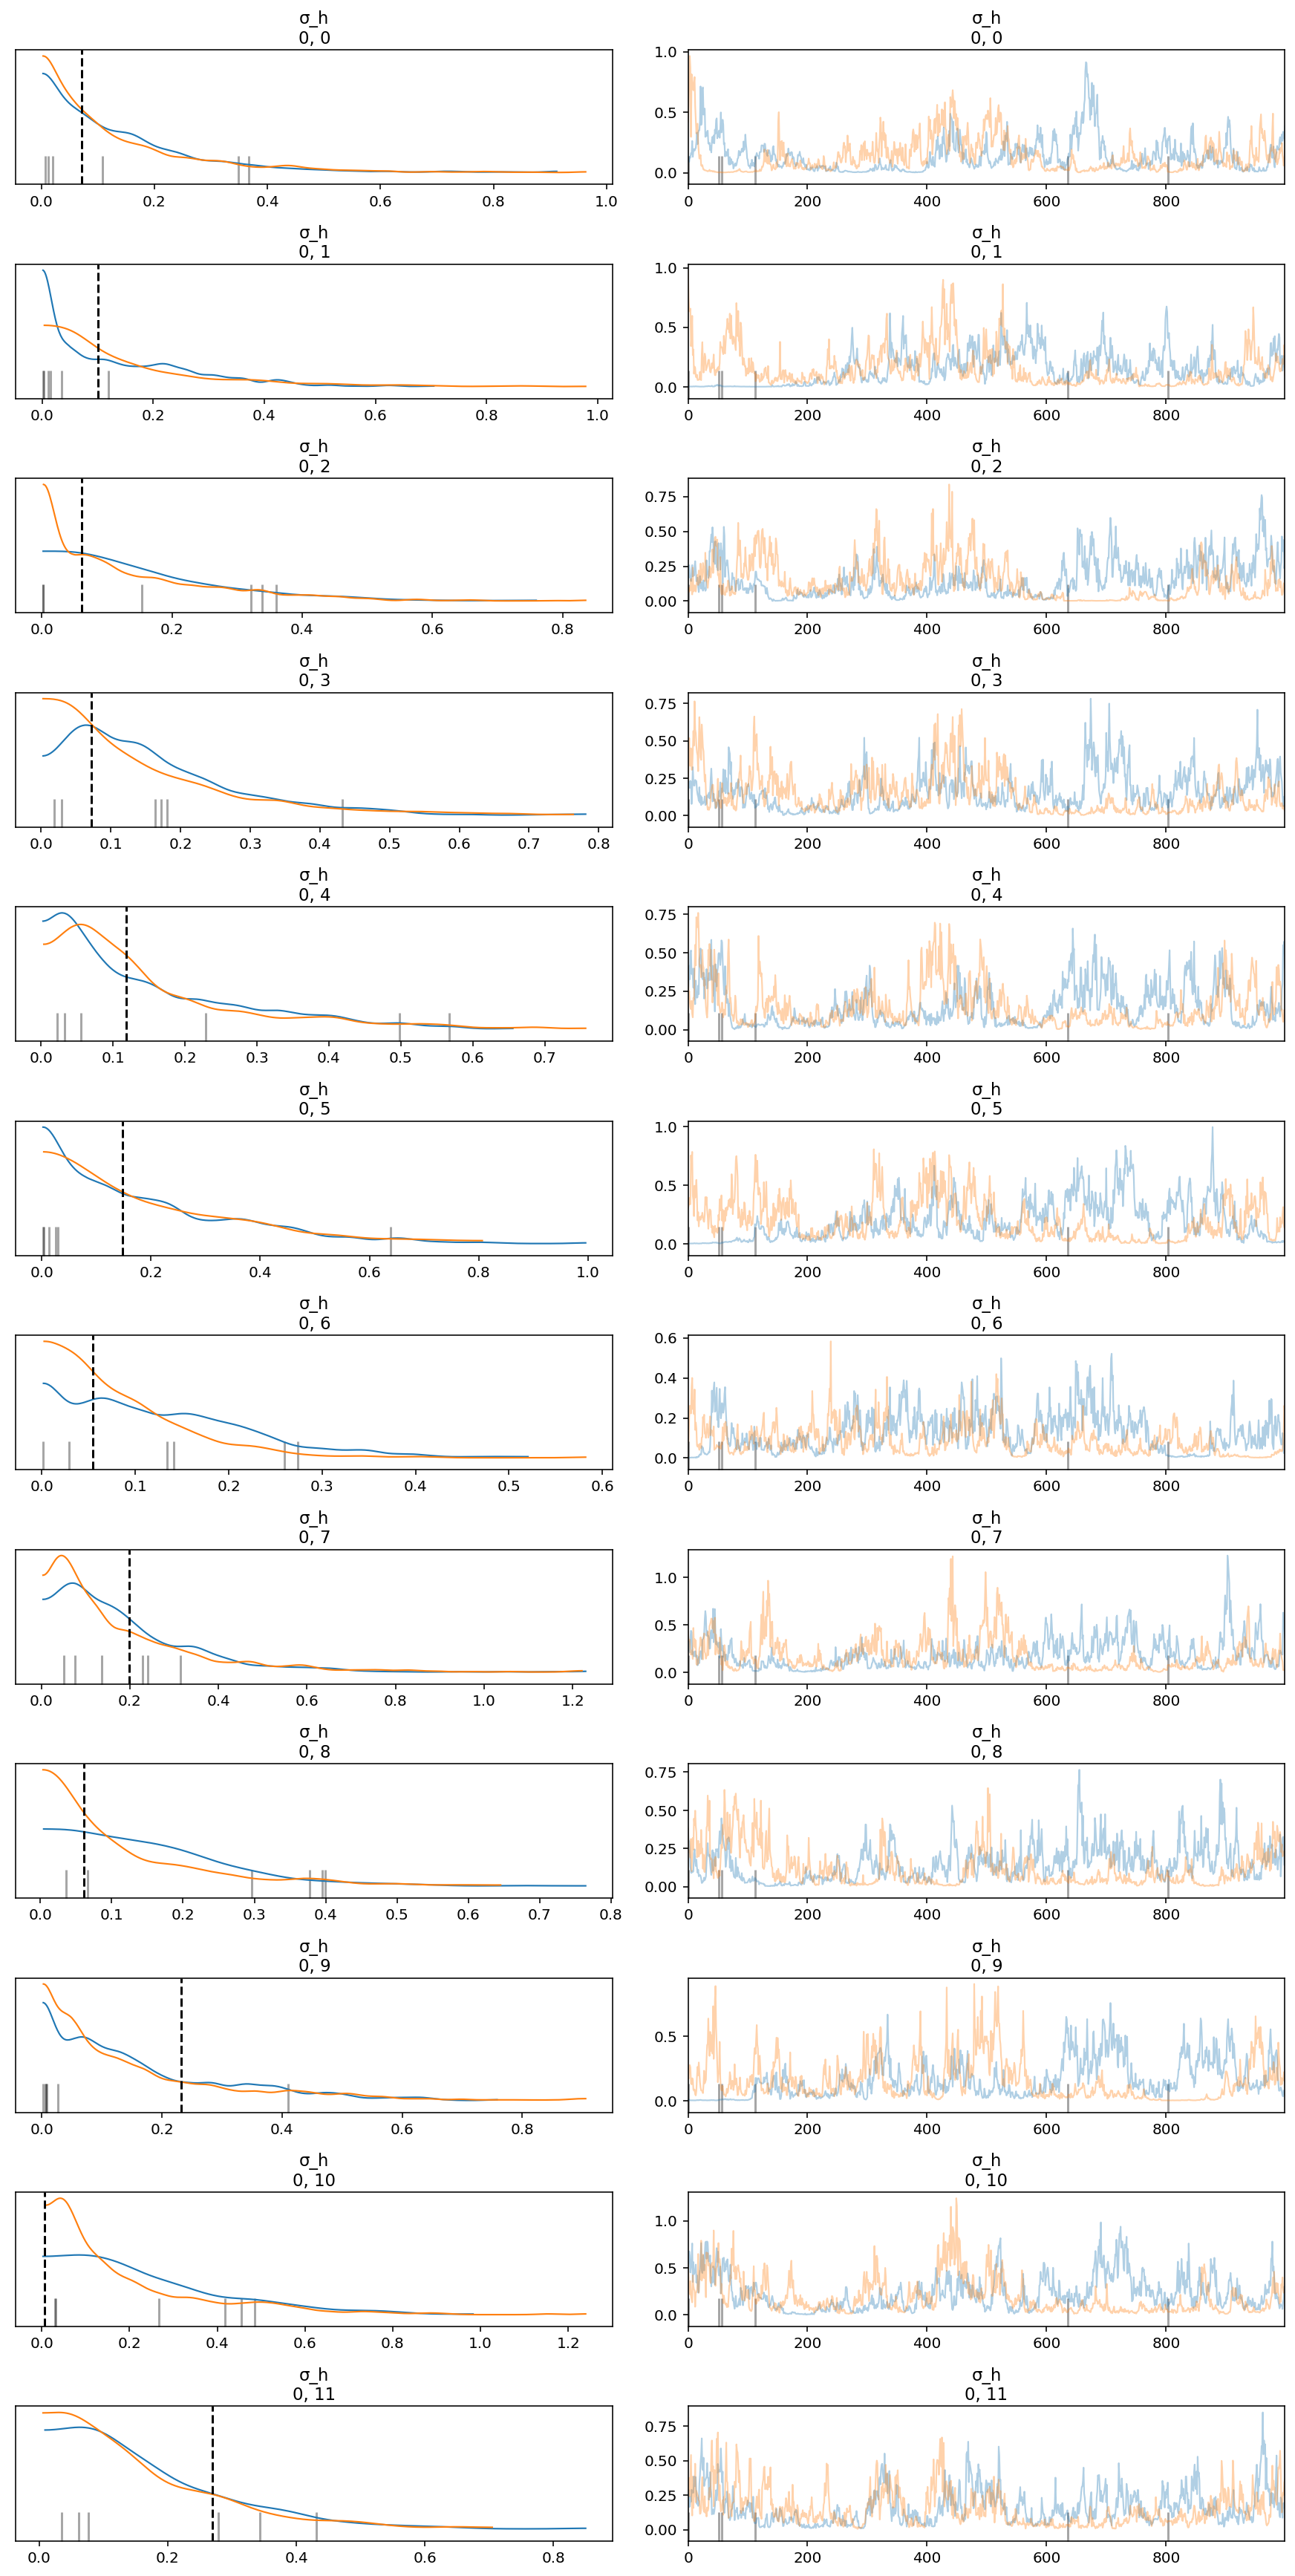

In [19]:
known_values = sp7_sbc_res.priors["σ_h"].flatten().tolist()

axes = az.plot_trace(sp7_mcmc, "σ_h", compact=False)
for ax, known_val in zip(axes[:, 0], known_values):
    ax.axvline(x=known_val, color="k", linestyle="--")
plt.show()

In [20]:
az.summary(sp7_mcmc, var_names=["σ_h"]).assign(
    real_values=sp7_sbc_res.priors["σ_h"].flatten()
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
σ_h[0,0]   0.138  0.140   0.002    0.395      0.020    0.014      35.0   
σ_h[0,1]   0.149  0.147   0.001    0.419      0.034    0.024      10.0   
σ_h[0,2]   0.146  0.131   0.002    0.395      0.040    0.029       8.0   
σ_h[0,3]   0.148  0.126   0.002    0.388      0.028    0.020      12.0   
σ_h[0,4]   0.149  0.136   0.003    0.415      0.021    0.015      42.0   
σ_h[0,5]   0.196  0.172   0.001    0.519      0.048    0.035      10.0   
σ_h[0,6]   0.106  0.088   0.001    0.261      0.016    0.011      28.0   
σ_h[0,7]   0.180  0.165   0.003    0.479      0.027    0.019      18.0   
σ_h[0,8]   0.135  0.120   0.003    0.363      0.026    0.019      18.0   
σ_h[0,9]   0.160  0.153   0.002    0.458      0.024    0.017      20.0   
σ_h[0,10]  0.212  0.188   0.004    0.568      0.034    0.025      25.0   
σ_h[0,11]  0.159  0.127   0.007    0.396      0.018    0.013      34.0   

           ess_tail  r_hat  real_values  
σ_h[0,0]       85.0   1.02     0.071619  
σ_h[0,1]       12.0   1.15     0.101389  
σ_h[0,2]       39.0   1.20     0.060964  
σ_h[0,3]       74.0   1.15     0.072233  
σ_h[0,4]      132.0   1.05     0.118477  
σ_h[0,5]       42.0   1.15     0.148154  
σ_h[0,6]       54.0   1.08     0.054469  
σ_h[0,7]       90.0   1.11     0.199104  
σ_h[0,8]       96.0   1.10     0.061263  
σ_h[0,9]       42.0   1.11     0.231970  
σ_h[0,10]      93.0   1.10     0.006446  
σ_h[0,11]     142.0   1.05     0.269312

In [21]:
mu_a_posterior = (
    az.summary(sp7_mcmc, var_names=["μ_a"], hdi_prob=PYMC3.HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="parameter",
        idx1=genes,
        idx2=cell_lines,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
    .assign(real_values=sp7_sbc_res.priors["μ_a"].flatten())
)

mu_a_posterior.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0  μ_a[0,0]  2.885  0.370     2.286      3.435      0.018    0.013     439.0   
1  μ_a[0,1]  2.867  0.371     2.265      3.423      0.018    0.013     413.0   
2  μ_a[0,2]  2.823  0.383     2.248      3.439      0.018    0.013     450.0   
3  μ_a[0,3]  2.905  0.372     2.312      3.481      0.019    0.013     395.0   
4  μ_a[0,4]  2.933  0.381     2.325      3.511      0.025    0.018     214.0   

   ess_tail  r_hat hugo_symbol  depmap_id  real_values  
0     730.0   1.02       gene0  cellline0     2.611423  
1     634.0   1.01       gene0  cellline8     2.512419  
2     884.0   1.01       gene0  cellline2     2.551952  
3     664.0   1.02       gene0  cellline4     2.606226  
4     694.0   1.02       gene0  cellline6     2.657033

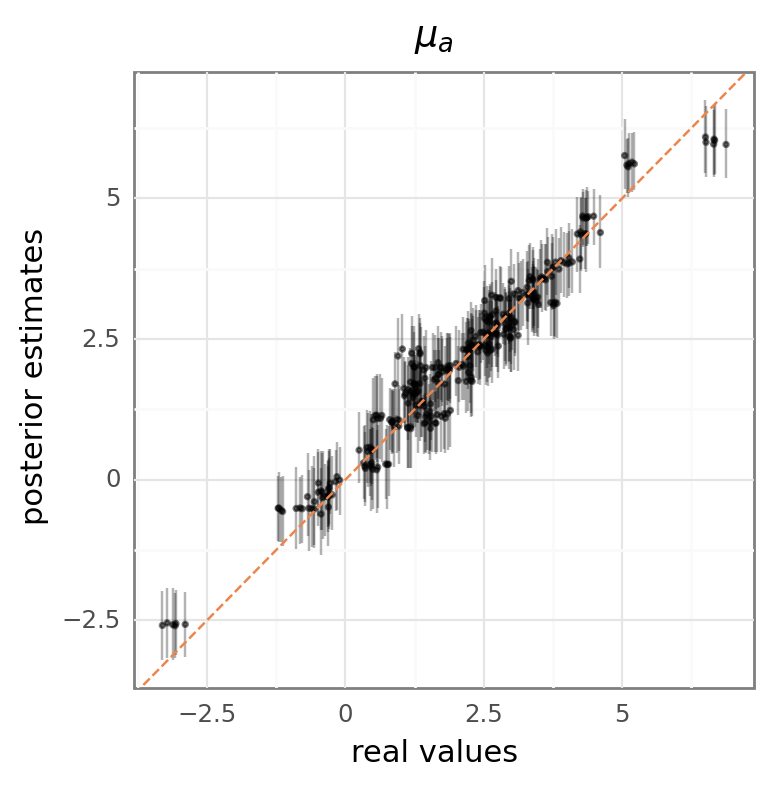

<ggplot: (8734092558797)>

In [22]:
(
    gg.ggplot(mu_a_posterior, gg.aes(x="real_values", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.3)
    + gg.geom_point(alpha=0.5, size=0.5)
    + gg.geom_abline(slope=1, intercept=0, linetype="--", color=SeabornColor.ORANGE)
    + gg.labs(x="real values", y="posterior estimates", title=r"$\mu_a$")
)

## Posterior predictions

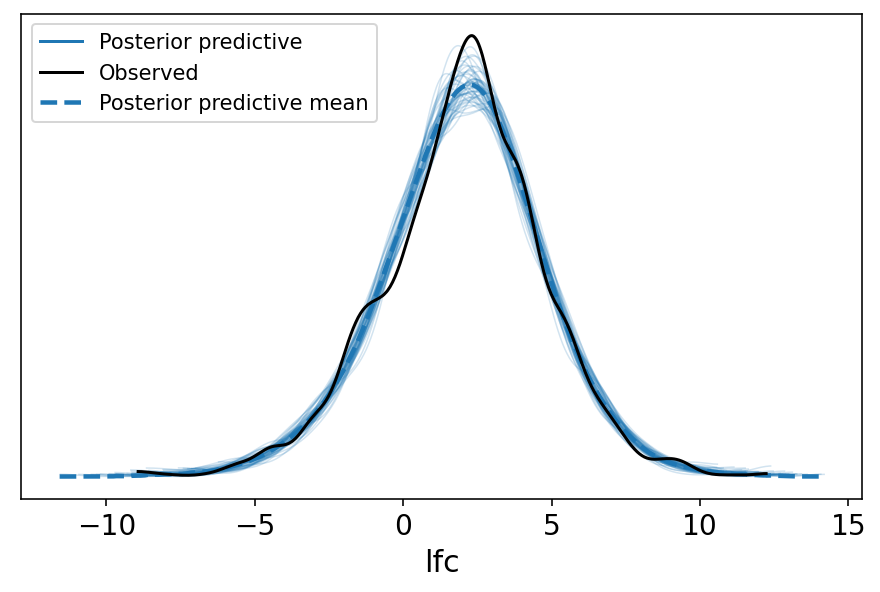

In [23]:
az.plot_ppc(sp7_mcmc, num_pp_samples=50);

In [24]:
sp7_ppc_values = sp7_mcmc.posterior_predictive["lfc"].values.squeeze()
sp7_ppc_hdi = az.hdi(sp7_ppc_values, hdi_prob=PYMC3.HDI_PROB)
sp7_ppc = pd.DataFrame(
    {
        "ppc_mean": sp7_ppc_values.mean(axis=0),
        "ppc_hdi_low": sp7_ppc_hdi[:, 0],
        "ppc_hdi_high": sp7_ppc_hdi[:, 1],
    }
)

sp7_ppc.head()

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


ppc_mean  ppc_hdi_low  ppc_hdi_high
0  3.560233     0.435702      6.157327
1  2.774793     0.823464      5.737690
2  2.583236     0.123725      5.369765
3  2.643578     0.209331      5.372292
4  3.171630     0.344396      5.596420

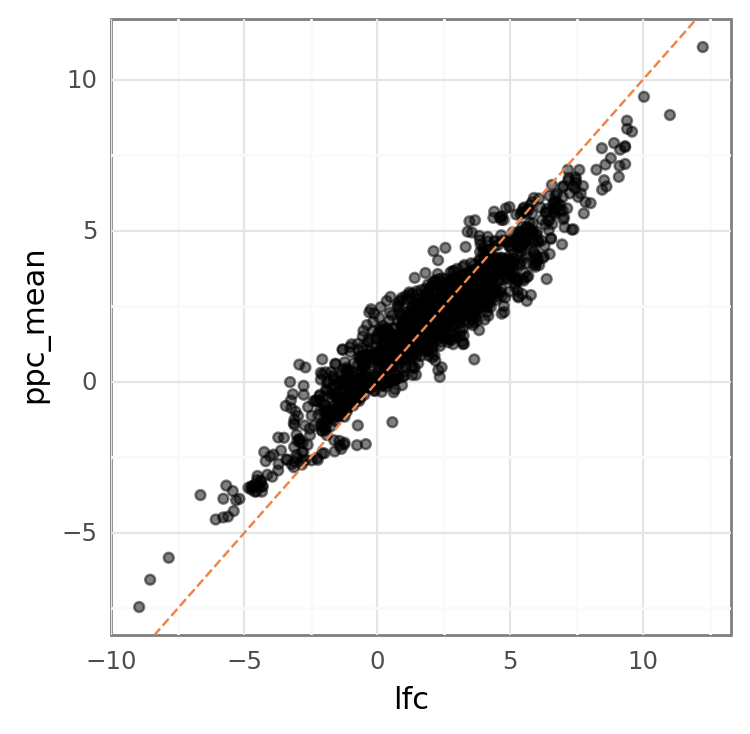

<ggplot: (8734092711789)>

In [25]:
mock_data_ppc = mock_data.merge(sp7_ppc, left_index=True, right_index=True)

(
    gg.ggplot(mock_data_ppc, gg.aes(x="lfc", y="ppc_mean"))
    + gg.geom_point(alpha=0.5)
    + gg.geom_abline(slope=1, intercept=0, linetype="--", color=SeabornColor.ORANGE)
)

## Sp7 with all covariates

In [26]:
sp7_config = SpecletSevenConfiguration(
    cell_line_cna_cov=True,
    gene_cna_cov=True,
    rna_cov=True,
    mutation_cov=True,
    batch_cov=True,
)

sp7_covs = SpecletSeven("sp7-expt-covs", debug=True, config=sp7_config)

In [27]:
if True:
    sp7_covs._reset_model_and_results()
    sp7_covs.cache_manager.clear_mcmc_cache()
    sp7_covs.cache_manager.clear_advi_cache()

[07/14/21 14:04:27] WARNING  Reseting all model and results.             ]8;id=1626285867.160643-644797;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:144

In [28]:
sp7_covs_sbc_dir = sp7_covs.cache_manager.cache_dir / "sbc"

if not sp7_covs_sbc_dir.exists():
    sp7_covs_sbc_dir.mkdir()


mock_data_covs: pd.DataFrame
sp7_covs_sbc_res: sbc.SBCResults
sp7_covs_sbc_fm: sbc.SBCFileManager

try:
    print("Trying to retrieve SBC data and results.")
    mock_data_covs, sp7_covs_sbc_res, sp7_covs_sbc_fm = sp7_covs.get_sbc(
        sp7_covs_sbc_dir
    )
    print("Successfully retrieved SBC results from cache.")
except CacheDoesNotExistError:
    print("Unable to retrieve SBC results from cache --> running SBC")
    sp7_covs.run_simulation_based_calibration(
        results_path=sp7_covs_sbc_dir,
        fit_method=ModelFitMethod.MCMC,
        random_seed=RANDOM_SEED,
        size=MockDataSize.MEDIUM,
        fit_kwargs={
            "draws": 1000,
            "tune": 4000,
            "chains": 2,
            "cores": 2,
            "prior_pred_samples": 1000,
            "post_pred_samples": 1000,
            "target_accept": 0.95,
        },
    )
    mock_data_covs = sp7_covs.data_manager.get_data()
    sp7_covs_sbc_fm = sbc.SBCFileManager(sp7_covs_sbc_dir)
    sp7_covs_sbc_res = sp7_covs_sbc_fm.get_sbc_results()
except Exception as err:
    print("Unexpected error.")
    print(err)

Trying to retrieve SBC data and results.


[07/14/21 14:04:28] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626285868.096007-861342;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626285868.1010137-641141;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

Successfully retrieved SBC results from cache.


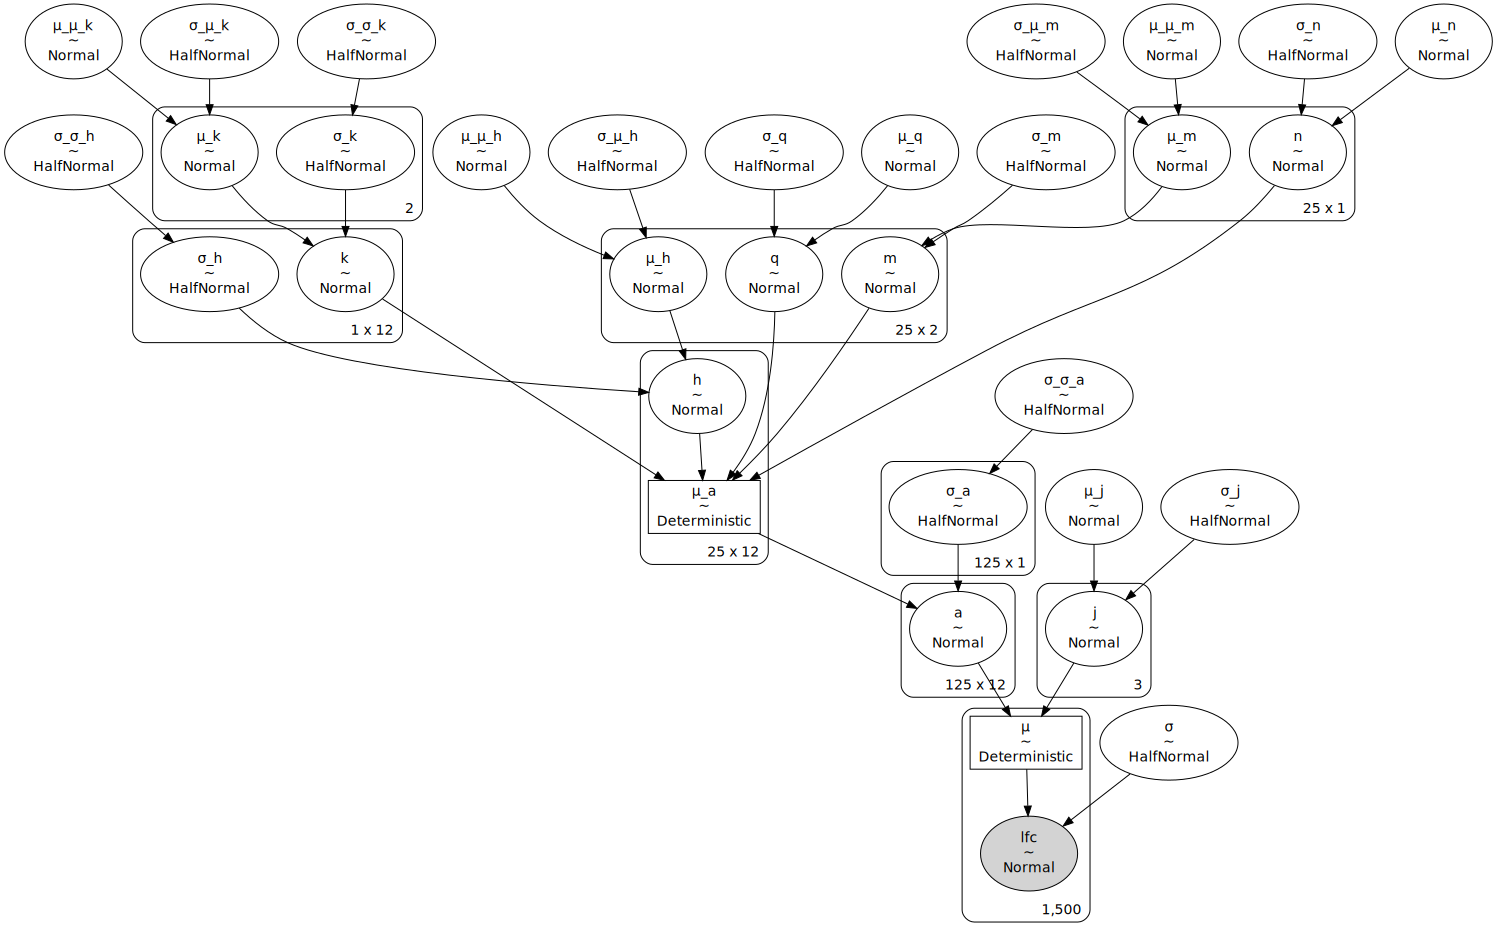

In [41]:
pm.model_to_graphviz(sp7_covs.model)

In [29]:
with sp7_covs.model:
    prior_dist = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

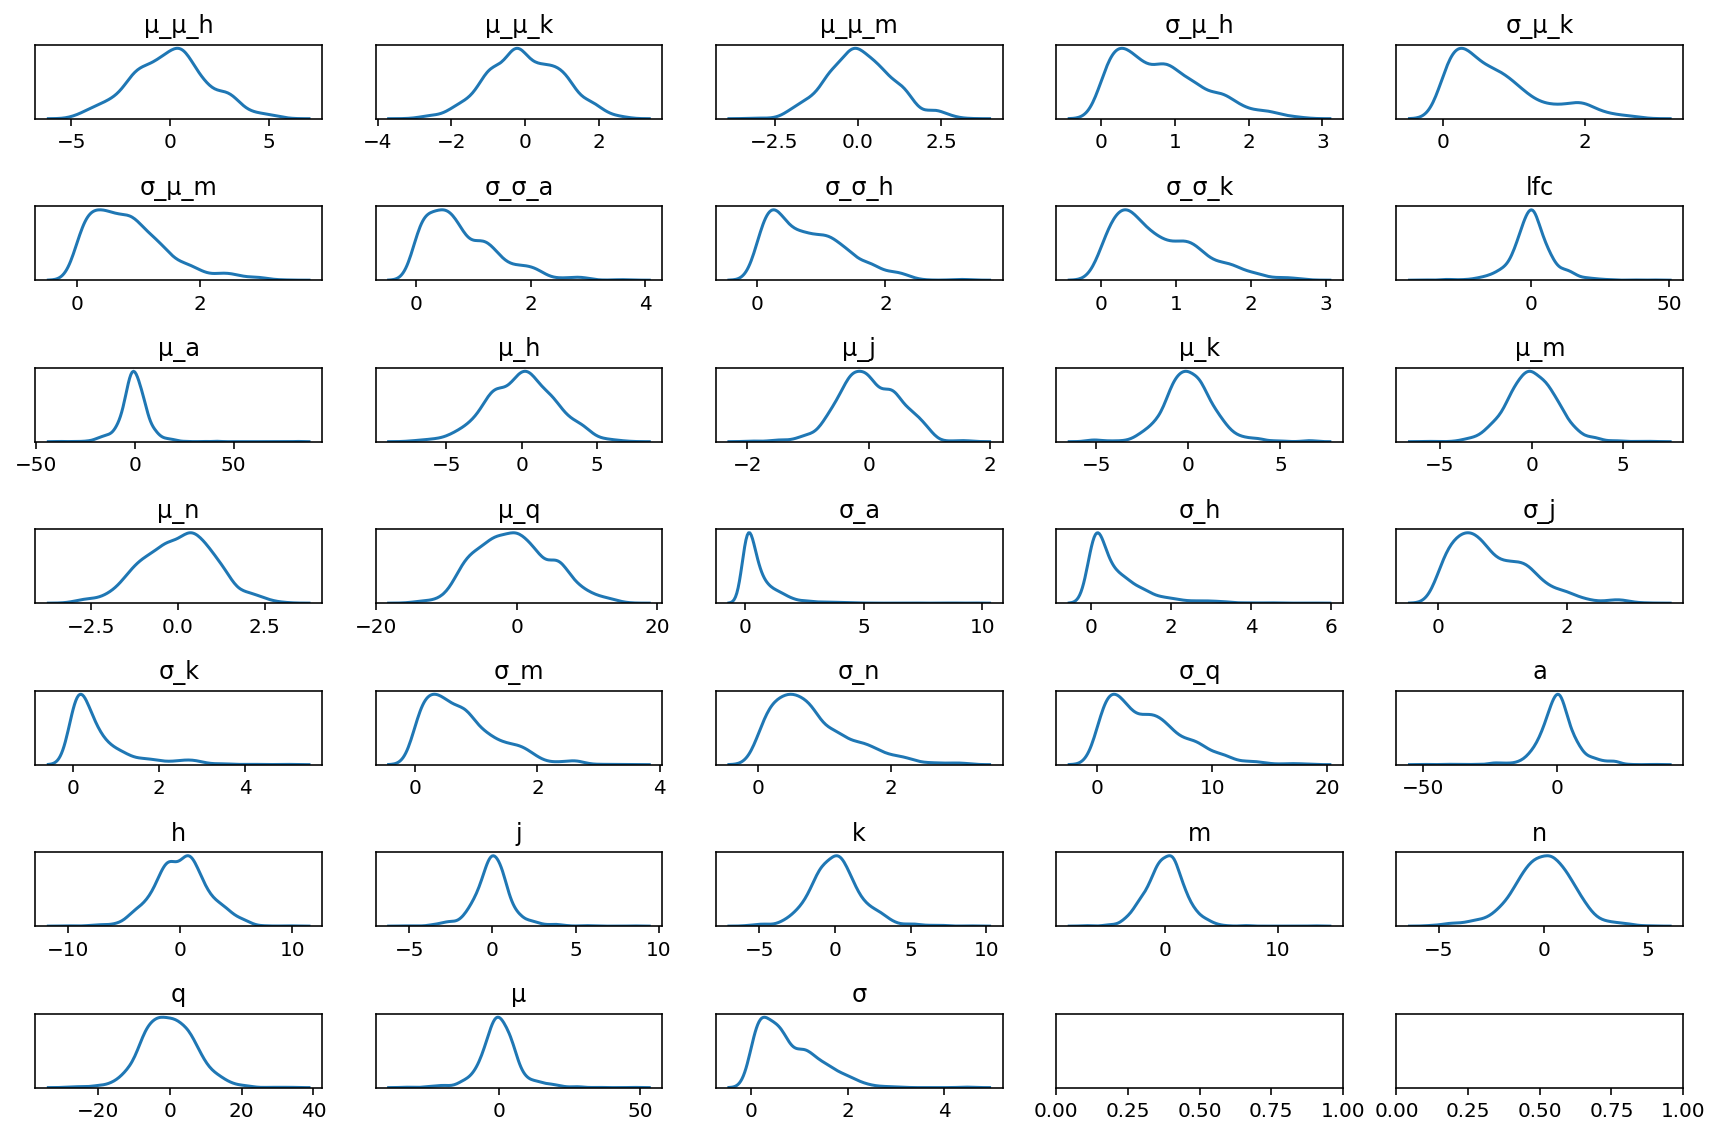

In [30]:
fig, axes = pmanal.plot_all_priors(
    prior_dist, (7, 5), (12, 8), rm_var_regex="log__|logodds_|offset"
)
for ax in axes.flatten():
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
fig.tight_layout()
plt.show()

In [31]:
sp7_covs_mock_data_cellline_info = (
    mock_data_covs.drop(columns=["sgrna_target_chr", "sgrna", "lfc"])
    .drop_duplicates()
    .reset_index(drop=True)
)
sp7_covs_mock_data_cellline_info.head()

depmap_id hugo_symbol   lineage p_dna_batch   screen  copy_number  \
0  cellline0       gene0  lineage0      batch0  screen0     1.113329   
1  cellline8       gene0  lineage0      batch0  screen0     0.845558   
2  cellline2       gene0  lineage0      batch2  screen0     1.075695   
3  cellline4       gene0  lineage0      batch2  screen0     1.056961   
4  cellline6       gene0  lineage0      batch1  screen1     0.664194   

    rna_expr  is_mutated  copy_number_cellline  copy_number_gene  \
0  14.925597           0              0.082580          0.134077   
1  14.305343           0             -0.159825         -0.133694   
2  14.883380           0              0.127801          0.096443   
3  14.903415           0              0.002152          0.077709   
4  14.206946           0             -0.357433         -0.315057   

   rna_expr_gene_lineage  copy_number_cellline  copy_number_gene  
0               1.026061              0.082580          0.134077  
1              -1.062249             -0.159825         -0.133694  
2               0.886523              0.127801          0.096443  
3               0.952789              0.002152          0.077709  
4              -1.401296             -0.357433         -0.315057

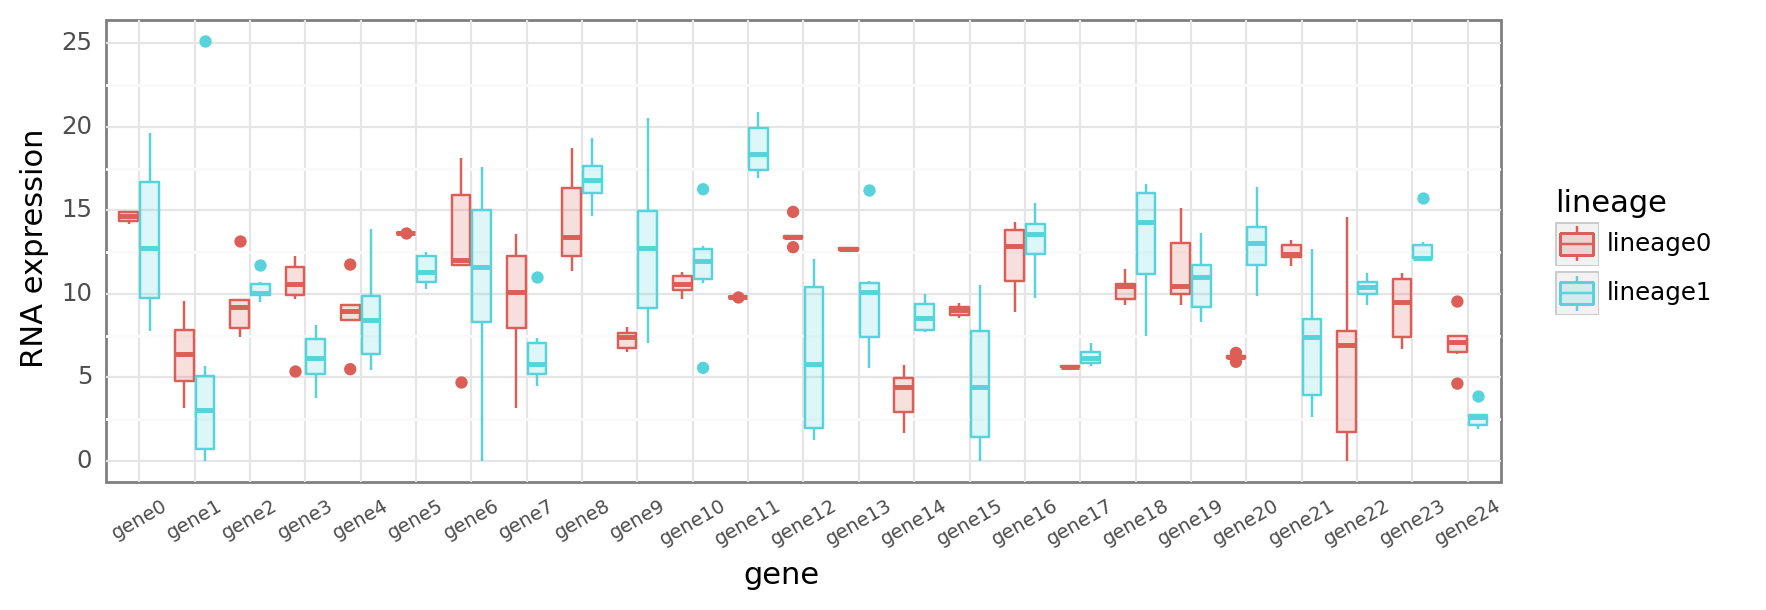

<ggplot: (8734086019106)>

In [32]:
(
    gg.ggplot(sp7_covs_mock_data_cellline_info, gg.aes(x="hugo_symbol", y="rna_expr"))
    + gg.geom_boxplot(gg.aes(color="lineage", fill="lineage"), alpha=0.2)
    + gg.scale_color_hue()
    + gg.scale_fill_hue()
    + gg.theme(axis_text_x=gg.element_text(size=7, angle=30), figure_size=(9, 3))
    + gg.labs(x="gene", y="RNA expression")
)

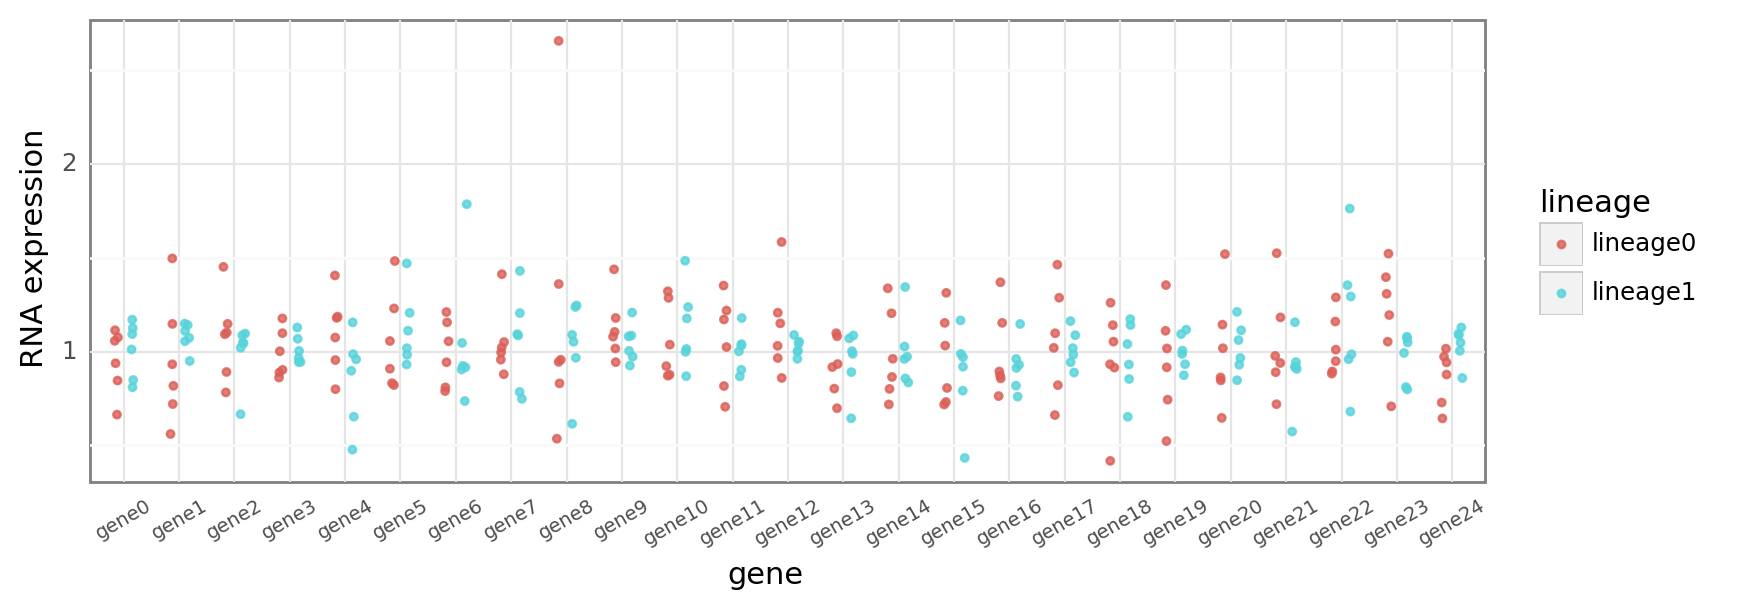

<ggplot: (8734085380699)>

In [33]:
(
    gg.ggplot(
        sp7_covs_mock_data_cellline_info, gg.aes(x="hugo_symbol", y="copy_number")
    )
    + gg.geom_point(
        gg.aes(color="lineage"),
        alpha=0.8,
        size=1,
        position=gg.position_jitterdodge(
            jitter_width=0.2, jitter_height=0, dodge_width=0.6, random_state=0
        ),
    )
    + gg.scale_color_hue()
    + gg.theme(axis_text_x=gg.element_text(size=7, angle=30), figure_size=(9, 3))
    + gg.labs(x="gene", y="RNA expression")
)

In [34]:
sp7_covs_mcmc = sp7_covs_sbc_res.inference_obj

In [35]:
az.summary(sp7_covs_mcmc, var_names="k", hdi_prob=PYMC3.HDI_PROB).assign(
    real_values=sp7_covs_sbc_res.priors["k"].flatten()
)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
k[0,0]   0.772  0.779    -0.499      1.997      0.311    0.231       6.0   
k[0,1]   0.845  0.713    -0.282      1.959      0.280    0.208       7.0   
k[0,2]   0.816  0.725    -0.263      2.071      0.322    0.242       5.0   
k[0,3]   0.656  0.807    -0.764      1.815      0.374    0.283       5.0   
k[0,4]   0.639  0.941    -0.842      2.075      0.436    0.330       5.0   
k[0,5]   0.941  0.701    -0.134      2.005      0.280    0.208       6.0   
k[0,6]   0.662  0.816    -0.589      2.029      0.289    0.212       8.0   
k[0,7]   0.885  0.835    -0.645      2.073      0.256    0.186      10.0   
k[0,8]   0.706  0.861    -0.734      2.057      0.335    0.248       7.0   
k[0,9]   0.746  0.840    -0.539      2.157      0.331    0.245       6.0   
k[0,10]  0.654  0.883    -0.708      2.194      0.351    0.260       6.0   
k[0,11]  0.711  0.834    -0.611      2.110      0.330    0.245       6.0   

         ess_tail  r_hat  real_values  
k[0,0]       43.0   1.29     2.444940  
k[0,1]       55.0   1.27     2.407721  
k[0,2]       32.0   1.33     2.194218  
k[0,3]       43.0   1.35     2.603053  
k[0,4]       19.0   1.38     2.328180  
k[0,5]       43.0   1.26     2.566870  
k[0,6]       42.0   1.20     2.546067  
k[0,7]       37.0   1.15     2.538456  
k[0,8]       39.0   1.24     2.537547  
k[0,9]       41.0   1.24     2.553933  
k[0,10]      36.0   1.25     2.536929  
k[0,11]      34.0   1.26     2.527300

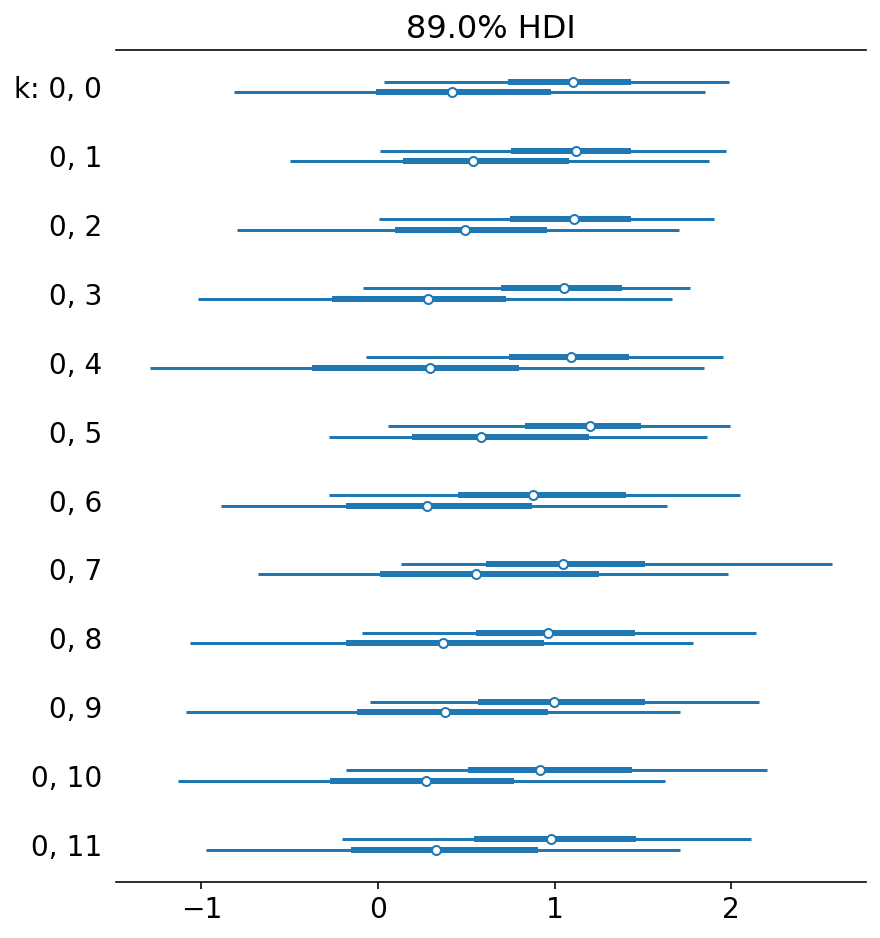

In [36]:
az.plot_forest(sp7_covs_mcmc, var_names="k", hdi_prob=PYMC3.HDI_PROB);

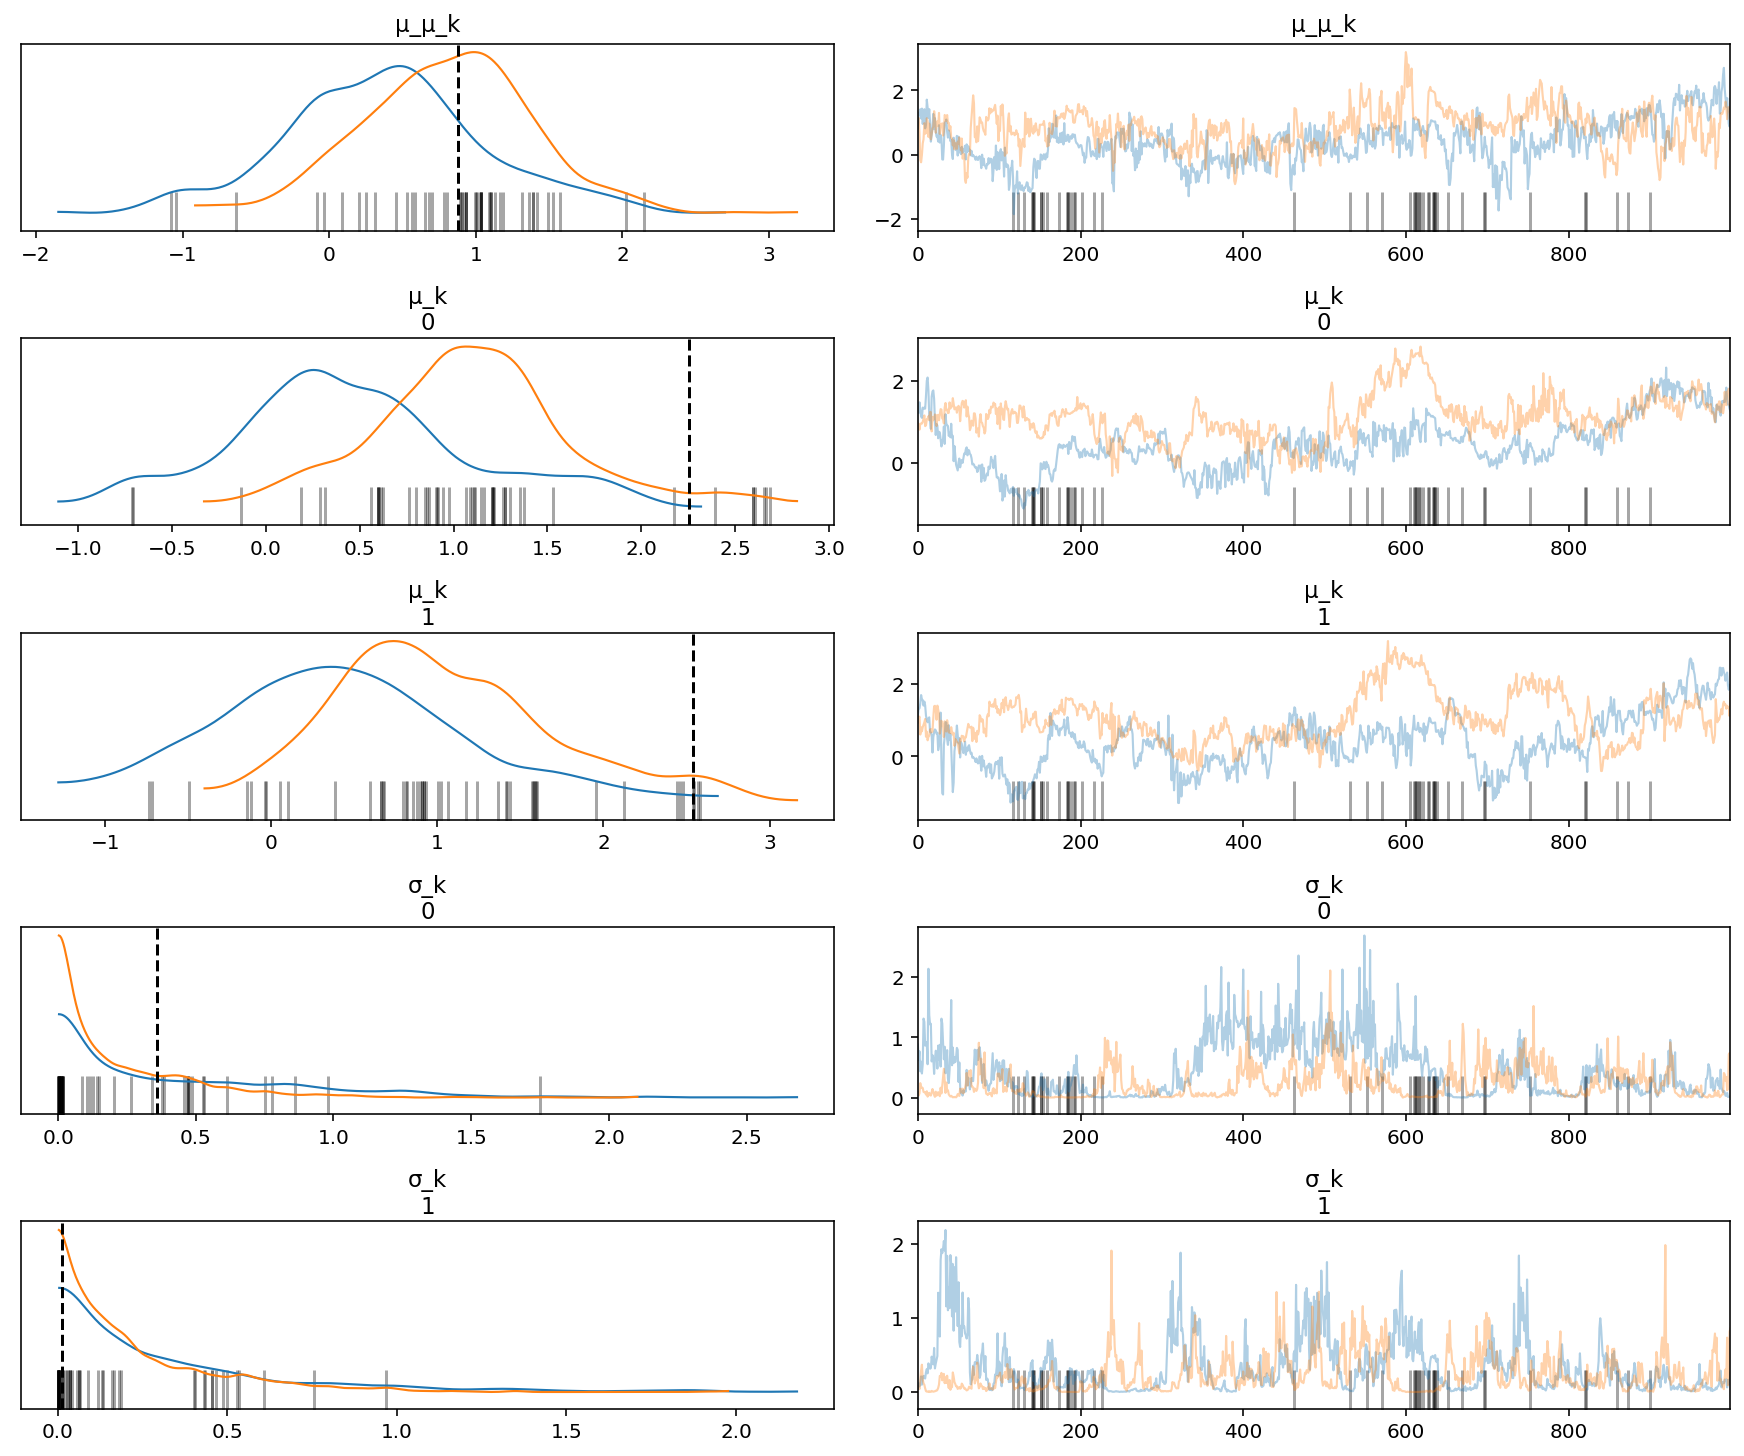

In [37]:
plot_vars = ["μ_μ_k", "μ_k", "σ_k"]
known_values = list(
    chain.from_iterable(
        [sp7_covs_sbc_res.priors[v].flatten().tolist() for v in plot_vars]
    )
)
axes = az.plot_trace(sp7_covs_mcmc, var_names=plot_vars, compact=False)

for ax, v in zip(axes[:, 0], known_values):
    ax.axvline(x=v, color="k", linestyle="--")

plt.show();

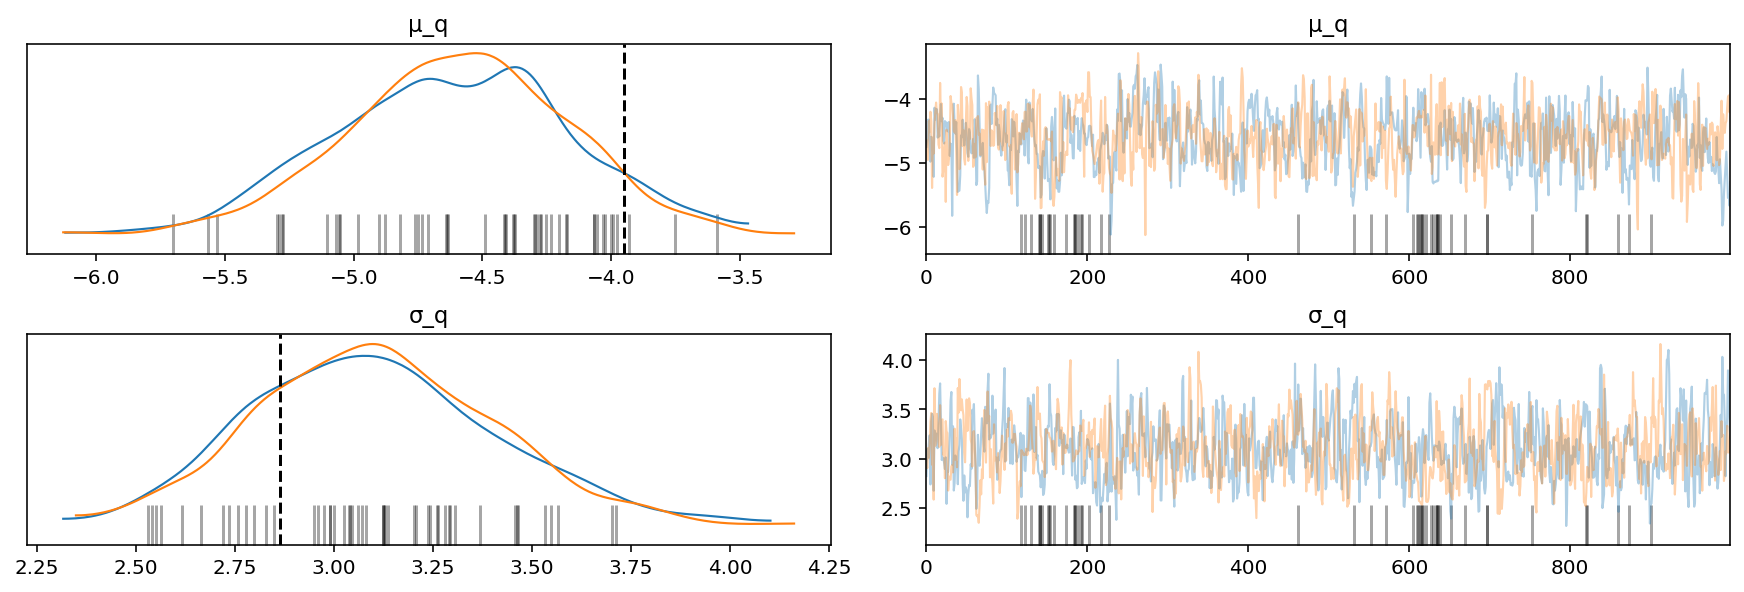

In [38]:
plot_vars = ["μ_q", "σ_q"]
known_values = list(
    chain.from_iterable(
        [sp7_covs_sbc_res.priors[v].flatten().tolist() for v in plot_vars]
    )
)
axes = az.plot_trace(sp7_covs_mcmc, var_names=plot_vars, compact=False)

for ax, v in zip(axes[:, 0], known_values):
    ax.axvline(x=v, color="k", linestyle="--")

plt.show();

---

In [39]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.84 minutes


In [40]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-14

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-229.o2.rc.hms.harvard.edu

Git branch: fit-models

pymc3     : 3.11.1
re        : 2.2.1
pandas    : 1.2.3
logging   : 0.5.1.2
matplotlib: 3.3.4
numpy     : 1.20.1
arviz     : 0.11.2
plotnine  : 0.7.1
seaborn   : 0.11.1
theano    : 1.0.5

